# Example: Elliptical Orbit

## Problem Statement

A geocentric elliptical orbit has a perigee radius of 9600 km and an apogee radius of 21,000 km. Calculate the time to fly from perigee to a true anomaly of $\theta =$ 120°. Then, calculate the true anomaly 3 hr after perigee.

## Solution

The first step in these problems is always to find the primary orbital parameters, $h$ and $e$. To obtain $e$, we can use the equation in terms of the distances to perigee and apogee, Eq. {eq}`ellipse-eccentricity-periapsis-apoapsis`:

$$e = \frac{r_a - r_p}{r_a + r_p}$$

In [1]:
# %matplotlib notebook
import numpy as np
from scipy.optimize import newton
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle, Arc, Rectangle

mu = 3.986004418E5 # km**3/s**2
theta = np.radians(120)

In [2]:
r_p = 9600  # km
r_a = 21_000 # km
e = (r_a - r_p)/(r_a + r_p)
print(round(e, 4))

0.3725


Then, the specific angular momentum is obtained from the orbit equation, solved for either the apogee or perigee radius:

$$h = \sqrt{r_p \mu \left(1 + e\right)}$$

In [3]:
h = np.sqrt(r_p * mu * (1 + e))
print(round(h, 2))

72471.7


Now, to find the time to fly to the true anomaly of 120°, we need to find $M_e$. $M_e$ is found from the eccentric anomaly, $E$, which is found from $\theta$:

$$E = 2 \tan^{-1}\left(\sqrt{\frac{1 - e}{1 + e}}\tan\frac{\theta}{2}\right)$$

In [4]:
E_1 = 2 * np.arctan(np.sqrt((1 - e)/(1 + e)) * np.tan(theta / 2)) % (2 * np.pi)
print(round(E_1, 3), f"{np.degrees(E_1):.3F}°")

1.728 99.011°


To convert $E$ to the range $[0, 2\pi)$, we take the modulus with $2\pi$. In most programming languages, Python and MATLAB included, the `arctan` function returns a value between $-\pi/2$ and $\pi/2$. When the result is multiplied by 2, it gives the range from $-\pi$ to $\pi$. We need to transform this angle to be in the range of $0$ to $2\pi$. To do so, we can take the **modulus** of the angle with $2\pi$.

The modulus is the remainder after division. In Python, the modulus operator is `%`, while in MATLAB, we have to use the function `mod(numerator, denominator)`. This works for both positive and negative numbers, and ensures that we get the correct angle for the appropriate quadrant.

Note that this means we do not need to use the `arctan2` function, which we can't really use anyways since we have an angle instead of two points in the coordinate system.

Then, the mean anomaly is found from Kepler's equation:

$$M_e = E - e\sin E$$

In [5]:
M_e1 = E_1 - e * np.sin(E_1)
print(round(M_e1, 3), f"{np.degrees(M_e1):.3F}°")

1.36 77.929°


Finally, calculating the time from the mean anomaly requires the period. The period requires the semimajor axis, $a$:

$$a = \frac{r_p}{1 - e}$$

and

$$T = \frac{2\pi}{\sqrt{\mu}}a^{3/2}$$

or Kepler's third law. Then, the time to the true anomaly of 120° is:

$$t = \frac{M_e T}{2 \pi}$$

In [6]:
a = r_p / (1 - e)
T = 2 * np.pi / np.sqrt(mu) * a**(3 / 2)
t_1 = M_e1 * T / (2 * np.pi)
print(a, T, t_1, t_1 / 3600)

15300.0 18834.24114907306 4077.043054361004 1.1325119595447233


The total time is 4,077 seconds or just over 1 hour.

Now, let's calculate the true anomaly about 2 hours later, after 3 total hours since perigee have elapsed. Since we already have the orbital eccentricity and specific angular momentum, we can start by finding the mean anomaly after 3 hours.

In [7]:
t_2 = 3  # hr
M_e2 = 2 * np.pi * t_2 * 3600 / T
print(round(M_e2, 3))

3.603


Now, we need to solve Kepler's equation to find the eccentric anomaly, $E$. Since the equation is transcendental in $E$, we need to use the Newton solver in SciPy. Since we know the derivative, we will define two Python functions:

1. Kepler's equation, $f(E) = 0$
2. The derivative of Kepler's equation with respect to $E$, $f'(E)$

In [8]:
def kepler(E, M_e, e):
    """Kepler's equation, to be used in a Newton solver."""
    return E - e * np.sin(E) - M_e

def d_kepler_d_E(E, M_e, e):
    """The derivative of Kepler's equation, to be used in a Newton solver.
    
    Note that the argument M_e is unused, but must be present so the function
    arguments are consistent with the kepler function.
    """
    return 1 - e * np.cos(E)

E_2 = newton(func=kepler, fprime=d_kepler_d_E, x0=np.pi, args=(M_e2, e))
print(round(E_2, 3))

3.479


With this value for $E$, we can calculate the value for $\theta$. To avoid sign problems, we will use the tangent formula, rather than the cosine formula:

$$\tan\frac{\theta}{2} = \sqrt{\frac{1 + e}{1 - e}} \tan\frac{E}{2}$$

or

$$\theta = 2\tan^{-1}\sqrt{\frac{1 + e}{1 - e}} \tan\frac{E}{2}$$

Note here that we have to apply the modulus operator again.

In [9]:
theta_2 = (2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E_2 / 2))) % (2 * np.pi)
print(round(theta_2, 3), f"{np.degrees(theta_2):.3F}°")

3.371 193.156°


### MATLAB Solution

In MATLAB, the following code will give the same result:

```matlab
function kepler
    mu = 3.986e5; % km^3/s^2
    r_p = 9600; % km
    r_a = 21000; % km
    e = (r_a - r_p)/(r_a + r_p);
    a = r_p/(1 - e);
    h = sqrt(r_p * mu * (1 + e));
    T = 2 * pi / sqrt(mu) * a^(3/2);
    t = 3; % hr
    M_e = 2 * pi * t * 3600 / T;

    function x = fun(E, M_e, e)
        x = E - e * sin(E) - M_e;
    end

    E = fzero(@(x) fun(x, M_e, e), [pi/2, 3*pi/2]);
    t2 = 2 * atan(sqrt((1 + e) / (1 - e)) * tan(E / 2));
    theta = mod(t2, 2 * pi);
    disp(rad2deg(theta))
end

```

We are using `fzero()` again to solve Kepler's equation. I'm not sure how sensitive `fzero()` will be to the initial guess.

Now, let's plot the orbit.

<IPython.core.display.Javascript object>


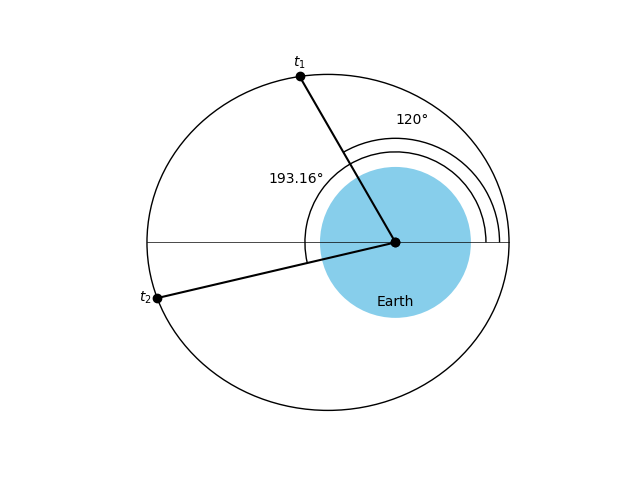

In [10]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.axis("off")

b = a * np.sqrt(1 - e**2)
ax.add_patch(Ellipse((0, 0), 2*a, 2*b, facecolor="None", edgecolor="black"))
ellipse_focus = np.sqrt(a**2 - b**2)
ax.add_patch(Circle((ellipse_focus, 0), 6378, facecolor="skyblue"))
ax.add_patch(Arc((ellipse_focus, 0), a, a, theta2=np.degrees(theta_2)))
ax.add_patch(Arc((ellipse_focus, 0), 1.15*a, 1.15*a, theta2=np.degrees(theta)))
ax.annotate(f"{np.degrees(theta):.0F}°", xy=(ellipse_focus, 10000))
ax.annotate(f"{np.degrees(theta_2):.2F}°", xy=(-5000, 5000))
ax.plot((-a, a), (0, 0), color="k", lw=0.5)
r_1 = a * (1 - e**2) / (1 + e * np.cos(theta))
x_1 = r_1 * np.cos(theta) + ellipse_focus
y_1 = r_1 * np.sin(theta)
r_2 = a * (1 - e**2) / (1 + e * np.cos(theta_2))
x_2 = r_2 * np.cos(theta_2) + ellipse_focus
y_2 = r_2 * np.sin(theta_2)
ax.plot((ellipse_focus, x_1), (0, y_1), "ko-")
ax.annotate("$t_1$", xy=(x_1, y_1 + 500), ha="center", va="bottom")
ax.plot((ellipse_focus, x_2), (0, y_2), "ko-")
ax.annotate("$t_2$", xy=(x_2 - 500, y_2), ha="right", va="center")
ax.annotate("Earth", xy=(ellipse_focus, -5000), ha="center", va="center");

## Example 2: Time in Earth's Shadow

A satellite is in a 500 km by 5000 km orbit with its apse line parallel to the line from the earth to the sun, as shown below. Find the time that the satellite is in the earth's shadow if:

1. the apogee is toward the sun
2. the perigee is toward the sun

### Solution

We start by finding $e$, $a$, and $T$, as usual. From the definition of the orbit, we find:

$$r_p = R_E + 500 \qquad r_a = R_E + 5000$$

In [11]:
r_p = 6378 + 500  # km
r_a = 6378 + 5000  # km
e = (r_a - r_p) / (r_p + r_a)
a = (r_a + r_p) / 2
T = 2 * np.pi / np.sqrt(mu) * a**(3/2)
print(f"{e=:.5F}, {a=:.0F} km, {T=:.2F} s")

e=0.24649, a=9128 km, T=8679.09 s


The figure below shows the shaded and sunlit regions of the orbit. The satellite will be in shade when its orbit intersects the lines at the edge of the earth, on the other side from the sun. When apogee is towards the sun, the satellite is shaded from $a$ to $b$, and when perigee is towards the sun, the satellite is shaded from $c$ to $d$.

<IPython.core.display.Javascript object>


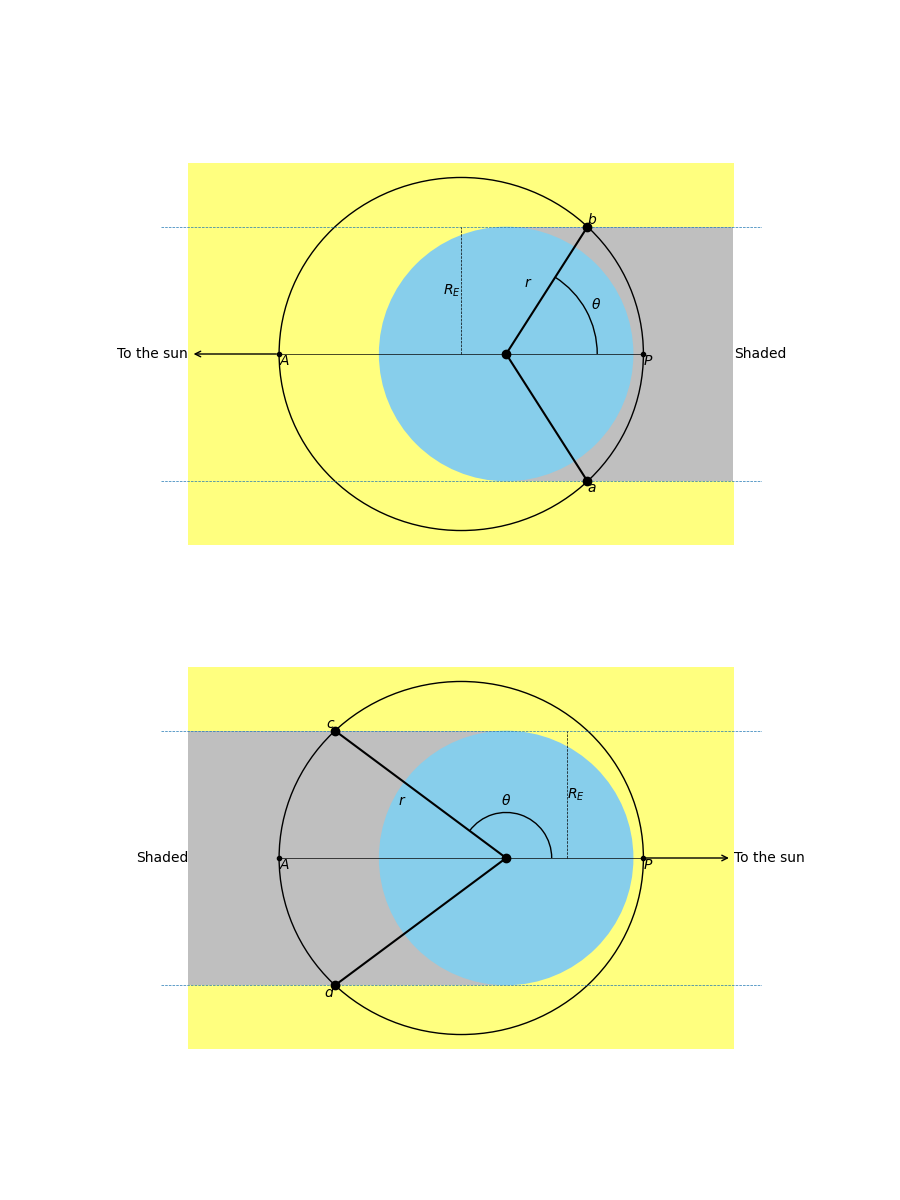

Text(-3162.735177982833, 3189.0, '$r$')

In [17]:
fig, (ax_1, ax_2) = plt.subplots(nrows=2, figsize=(9, 12))
R_E = 6378  # km
b = a * np.sqrt(1 - e**2)
ellipse_focus = np.sqrt(a**2 - b**2)

ax_1.add_patch(Rectangle((-1.5*a, -R_E), 1.5*a + ellipse_focus, 2*R_E, facecolor="yellow", alpha=0.5))
ax_1.add_patch(Rectangle((-1.5*a, R_E), 3*a, 0.5*R_E, facecolor="yellow", alpha=0.5))
ax_1.add_patch(Rectangle((-1.5*a, -R_E), 3*a, -0.5*R_E, facecolor="yellow", alpha=0.5))
ax_1.add_patch(Rectangle((ellipse_focus, -R_E), a + ellipse_focus, 2*R_E, facecolor="gray", alpha=0.5))
ax_2.add_patch(Rectangle((ellipse_focus, -R_E), 1.5*a - ellipse_focus, 2*R_E, facecolor="yellow", alpha=0.5))
ax_2.add_patch(Rectangle((-1.5*a, R_E), 3*a, 0.5*R_E, facecolor="yellow", alpha=0.5))
ax_2.add_patch(Rectangle((-1.5*a, -R_E), 3*a, -0.5*R_E, facecolor="yellow", alpha=0.5))
ax_2.add_patch(Rectangle((-1.5*a, -R_E), 1.5*a + ellipse_focus, 2*R_E, facecolor="gray", alpha=0.5))

for ax in (ax_1, ax_2):
    ax.set_aspect("equal")
    ax.axis("off")
    ax.add_patch(Ellipse((0, 0), 2*a, 2*b, facecolor="None", edgecolor="black"))
    ax.add_patch(Circle((ellipse_focus, 0), R_E, facecolor="skyblue"))
    ax.plot((-a, a), (0, 0), lw=0.5, marker="o", color="black", markersize=3)
    ax.axhline(R_E, lw=0.5, ls="--")
    ax.axhline(-R_E, lw=0.5, ls="--")

x_1 = R_E/np.tan(np.radians(57.423)) + ellipse_focus
ax_1.plot((x_1, ellipse_focus, x_1), (-R_E, 0, R_E), "k-o")
ax_1.annotate("$a$", xy=(x_1, -R_E), ha="left", va="top")
ax_1.annotate("$b$", xy=(x_1, R_E), ha="left", va="bottom")
ax_1.annotate("To the sun", xy=(-a, 0), xytext=(-1.5*a, 0), ha="right", va="center", arrowprops={"arrowstyle": "<-"})
ax_1.annotate("Shaded", xy=(1.5*a, 0), ha="left", va="center")
ax_1.annotate("$P$", xy=(a, 0), ha="left", va="top")
ax_1.annotate("$A$", xy=(-a, 0), ha="left", va="top")
ax_1.plot((0, 0), (0, R_E), "k--", lw=0.5)
ax_1.annotate("$R_E$", xy=(0, R_E/2), ha="right", va="center")
ax_1.add_patch(Arc((ellipse_focus, 0), a, a, theta2=57.423))
ax_1.annotate(r"$\theta$", xy=(a/1.4, 2500), ha="left", va="center")
ax_1.annotate("$r$", xy=(x_1/2, R_E/2), ha="left", va="bottom")

x_2 = R_E/np.tan(np.radians(143.36)) + ellipse_focus
ax_2.plot((x_2, ellipse_focus, x_2), (-R_E, 0, R_E), "k-o")
ax_2.annotate("$d$", xy=(x_2, -R_E), ha="right", va="top")
ax_2.annotate("$c$", xy=(x_2, R_E), ha="right", va="bottom")
ax_2.annotate("To the sun", xy=(a, 0), xytext=(1.5*a, 0), ha="left", va="center", arrowprops={"arrowstyle": "<-"})
ax_2.annotate("Shaded", xy=(-1.5*a, 0), ha="right", va="center")
ax_2.annotate("$P$", xy=(a, 0), ha="left", va="top")
ax_2.annotate("$A$", xy=(-a, 0), ha="left", va="top")
ax_2.plot((ellipse_focus + a/3, ellipse_focus + a/3), (0, R_E), "k--", lw=0.5)
ax_2.annotate("$R_E$", xy=(ellipse_focus + a/3, R_E/2), ha="left", va="center")
ax_2.add_patch(Arc((ellipse_focus, 0), a/2, a/2, theta2=143.36))
ax_2.annotate(r"$\theta$", xy=(ellipse_focus, 2500), ha="center", va="bottom")
ax_2.annotate("$r$", xy=(x_2/2, R_E/2), ha="left", va="top");

Then, we need to solve for the value of $\theta$ at $b$ and $c$. With this value of $\theta$, we can find the time to fly between the two points. This will tell us the time the satellite is in the shade.

From the figure, we can identify the relationship between $r$, $R_E$ and $\theta$:

$$r = \frac{R_E}{\sin\theta}$$

We also have the orbit equation:

$$r = \frac{a\left(1 - e^2\right)}{1 + e\cos\theta}$$


Now, we can set these two equations equal to each other and solve for $\theta$. We end up with a complicated equation for $\theta$:

$$e\cos\theta - \left(1 - e^2\right)\frac{a}{R_E}\sin\theta + 1 = 0$$

Now, we can solve this equation numerically. The example in the book solves it analytically, but frankly, I don't know that much trigonometry.

So, we need to find out how many roots to expect in this equation. One way to do that is to plot the equation over a suitable range and see how many times it crosses zero. The suitable range for this problem is $[0, 2\pi]$.

<IPython.core.display.Javascript object>


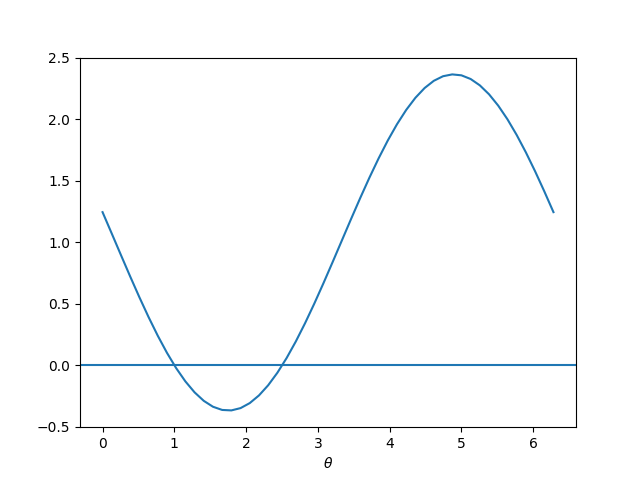

Text(0.5, 0, '$\\theta$')

In [19]:
def shadow(theta, e, a, R_E):
    """This function computes the angle θ in the shadow example problem.
    
    The arguments are the angle, the eccentricity, the semimajor axis, and
    the radius of the earth.
    
    This function is intended to be used in a root-finding algorithm.
    """
    return e * np.cos(theta) - (1 - e**2) * a / R_E * np.sin(theta) + 1

fig, ax_shadow = plt.subplots()
theta_range = np.linspace(0, 2 * np.pi)
ax_shadow.plot(theta_range, shadow(theta_range, e, a, R_E))
ax_shadow.axhline(0);
ax_shadow.set_xlabel(r"$\theta$");

From the plot, we can see there are two roots, one near $\theta$ = 1 and one near $\theta$ = 2.5, both in radians. Now we can use `scipy.optimize.newton()` to solve the equation.

In [20]:
theta_b = newton(func=shadow, x0=1, args=(e, a, R_E))
theta_c = newton(func=shadow, x0=2.5, args=(e, a, R_E))
print(f"{np.degrees(theta_b):.3F}°", f"{np.degrees(theta_c):.2F}°", )

57.423° 143.36°


Now we can use this value of $\theta$ to solve for $E$, then for the mean anomaly, and then for the time since perigee. These equations are given above.

In [26]:
E_b = (2 * np.arctan(np.sqrt((1 - e) / (1 + e)) * np.tan(theta_b / 2))) % (2 * np.pi)
M_eb = E_b - e * np.sin(E_b)
t_b = M_eb * T / (2 * np.pi)
print(
    f"{E_b=:.5F} rad",
    f"{M_eb=:.5F} rad",
    f"{t_b=:.2F} s",
    f"{2*t_b=:.2F} s",
    f"{t_b/30=:.2F} min",
    sep="\n"
)

E_b=0.80521 rad M_eb=0.62749 rad t_b=866.77 s 2*t_b=1733.54 s t_b/30=28.89 min


```{margin}
**Note:** There's a typo in the book in the solution for this part, it lists 28.98 minutes as the time, transposing the 9 and 8 in the decimals.
```

The time to fly from perigee to point $b$ is the same as the time to fly from point $a$ to perigee, because the orbit is symmetrical around the apse line. Therefore, the time the satellite is in shadow when apogee is towards the sun is a little less than half an hour, 28.89 minutes.

When perigee is towards the sun, then the satellite will be in shadow from point $c$ to point $d$. Again, since the orbit is symmetric around the apse line, the time to fly from $c$ to apogee is the same as the time from apogee to $d$. Thinking about this another way, the time that the satellite spends in the sun is the time from perigee to $c$ plus the time from $d$ to perigee. Therefore, the time in shadow is the period minus the time in the sun:

$$t = T - 2t_c$$

In [28]:
E_c = (2 * np.arctan(np.sqrt((1 - e) / (1 + e)) * np.tan(theta_c / 2))) % (2 * np.pi)
M_ec = E_c - e * np.sin(E_c)
t_c = M_ec * T / (2 * np.pi)
print(
    f"{E_c=:.5F} rad",
    f"{M_ec=:.5F} rad",
    f"{t_c=:.2F} s",
    f"{2*t_c=:.2F} s",
    f"{T/60 - t_c/30=:.2F} min",
    sep="\n"
)

E_c=2.33638 rad M_ec=2.15867 rad t_c=2981.81 s 2*t_c=5963.62 s T/60 - t_c/30=45.26 min


The time in shadow is just over 45 minutes when perigee points towards the sun. This result is intuitively correct because the satellite is travelling slower near apogee, due to Kepler's second law (equal areas in equal times).